In [50]:
from cutmix_keras import CutMixImageDataGenerator

In [51]:
train_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)_2/train"
val_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)_2/val"
test_root = "G:/大学学习/NTU/dataset/COVID-19_cut (train test split)_2/test"

In [52]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [57]:
batch_size = 10
image_data_generator = ImageDataGenerator(rescale=1/255)
training_dataset_1 = image_data_generator.flow_from_directory(
    train_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=True)
training_dataset_2 = image_data_generator.flow_from_directory(
    train_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=True)

Found 7581 images belonging to 3 classes.
Found 7581 images belonging to 3 classes.


In [58]:
validation_dataset = image_data_generator.flow_from_directory(
    val_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 1082 images belonging to 3 classes.


In [59]:
train_generator = CutMixImageDataGenerator(training_dataset_1, training_dataset_2, img_size=224, batch_size=10)

In [74]:
train_data_cutmix, train_labels_cutmix = next(train_generator)
print(train_data_cutmix.shape, train_labels_cutmix.shape)

(10, 224, 224, 3) (10, 3)


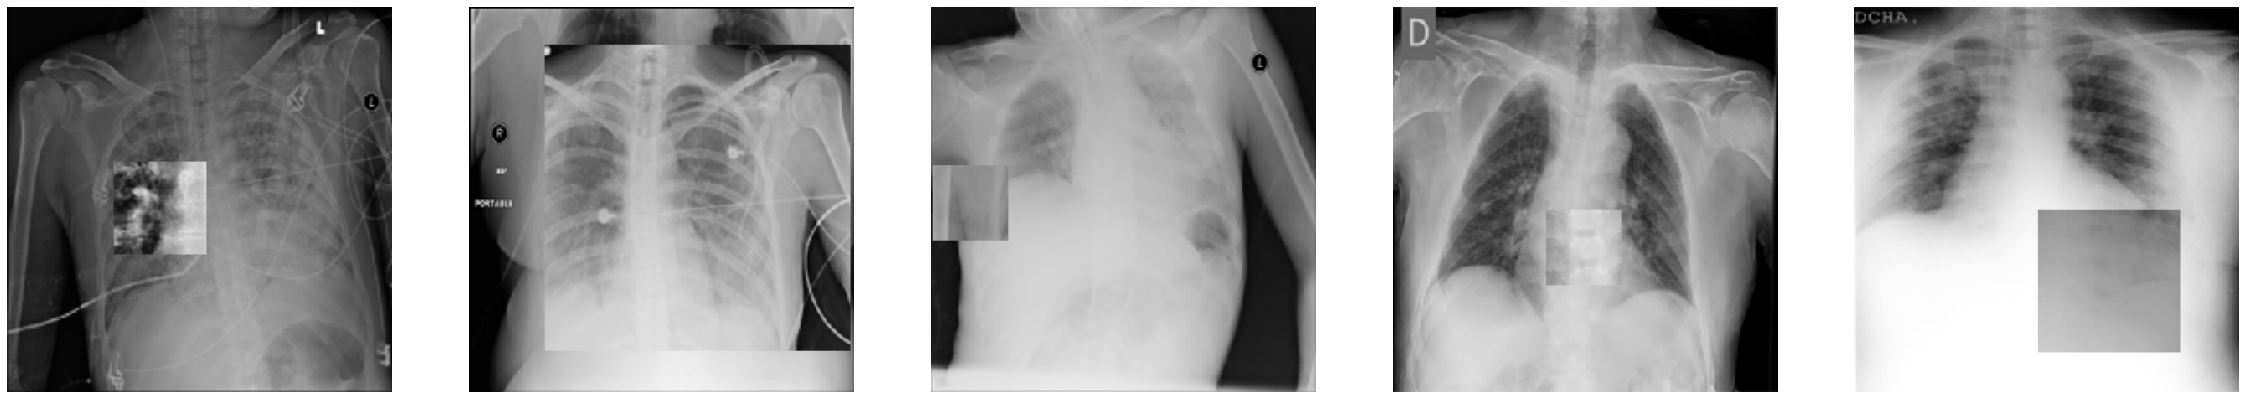

In [75]:
classes = ('COVID','Lung-Opacity','Normal')
plt.figure(figsize=(40, 20))
j = 1
for i in range(5):
    plt.subplot(1, 5, j)
    plt.imshow(train_data_cutmix[i])
    #plt.title(train_labels_cutmix[i], fontsize=30)
    plt.axis('off')
    j+=1
plt.show()

In [15]:
from keras.applications import densenet
from keras.initializers import GlorotNormal
d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))

In [16]:
d.output_shape

(None, 7, 7, 1024)

In [17]:
model = tf.keras.layers.Dropout(0)(d.output)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0)(model)
model = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(), activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.0001), 
                             bias_regularizer=tf.keras.regularizers.l2(0.0001))(model)
model = tf.keras.models.Model(inputs=d.input, outputs=model)
model.load_weights("../chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
for layer in model.layers[:200]:
    layer.trainable = False
for layer in model.layers[200:]:
    layer.trainable = True

In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.categorical_crossentropy, 
              metrics =  [TruePositives(name='tp'),
              FalsePositives(name='fp'),
              TrueNegatives(name='tn'),
              FalseNegatives(name='fn'), 
              'accuracy',
              Precision(name='precision'),
              Recall(name='recall')])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

 dense (Dense)                  (None, 3)            3075        ['dropout_1[0][0]']              
                                                                                                  
Total params: 7,040,579
Trainable params: 4,781,059
Non-trainable params: 2,259,520
__________________________________________________________________________________________________


In [20]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min'),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model_{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [21]:
history = model.fit_generator(train_generator, validation_data=validation_dataset, steps_per_epoch=train_generator.get_steps_per_epoch(), epochs=30, callbacks=my_callbacks)

D:\tmpdir\Temp\ipykernel_9260\2883497945.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=validation_dataset, steps_per_epoch=train_generator.get_steps_per_epoch(), epochs=30, callbacks=my_callbacks)


Epoch 1/30
948/948 [==============================] - 262s 259ms/step - loss: 0.6042 - tp: 6641.0000 - fp: 448.0000 - tn: 10398.0000 - fn: 5256.0000 - accuracy: 0.7951 - precision: 0.9368 - recall: 0.5582 - val_loss: 0.2065 - val_tp: 1021.0000 - val_fp: 50.0000 - val_tn: 2114.0000 - val_fn: 61.0000 - val_accuracy: 0.9501 - val_precision: 0.9533 - val_recall: 0.9436 - lr: 0.0010
Epoch 2/30
948/948 [==============================] - 104s 109ms/step - loss: 0.5093 - tp: 7038.0000 - fp: 241.0000 - tn: 10582.0000 - fn: 4882.0000 - accuracy: 0.8549 - precision: 0.9669 - recall: 0.5904 - val_loss: 0.1738 - val_tp: 1024.0000 - val_fp: 51.0000 - val_tn: 2113.0000 - val_fn: 58.0000 - val_accuracy: 0.9501 - val_precision: 0.9526 - val_recall: 0.9464 - lr: 0.0010
Epoch 3/30
948/948 [==============================] - 105s 111ms/step - loss: 0.4877 - tp: 7151.0000 - fp: 215.0000 - tn: 10687.0000 - fn: 4690.0000 - accuracy: 0.8635 - precision: 0.9708 - recall: 0.6039 - val_loss: 0.1644 - val_tp: 1038

Epoch 21/30
948/948 [==============================] - 106s 112ms/step - loss: 0.3767 - tp: 7427.0000 - fp: 25.0000 - tn: 10828.0000 - fn: 4463.0000 - accuracy: 0.9296 - precision: 0.9966 - recall: 0.6246 - val_loss: 0.1078 - val_tp: 1057.0000 - val_fp: 18.0000 - val_tn: 2146.0000 - val_fn: 25.0000 - val_accuracy: 0.9797 - val_precision: 0.9833 - val_recall: 0.9769 - lr: 1.0000e-06
Epoch 22/30
948/948 [==============================] - ETA: 0s - loss: 0.3771 - tp: 7440.0000 - fp: 20.0000 - tn: 10826.0000 - fn: 4457.0000 - accuracy: 0.9314 - precision: 0.9973 - recall: 0.6254
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
948/948 [==============================] - 106s 112ms/step - loss: 0.3771 - tp: 7440.0000 - fp: 20.0000 - tn: 10826.0000 - fn: 4457.0000 - accuracy: 0.9314 - precision: 0.9973 - recall: 0.6254 - val_loss: 0.1067 - val_tp: 1058.0000 - val_fp: 19.0000 - val_tn: 2145.0000 - val_fn: 24.0000 - val_accuracy: 0.9797 - val_precision: 0.9824 - val

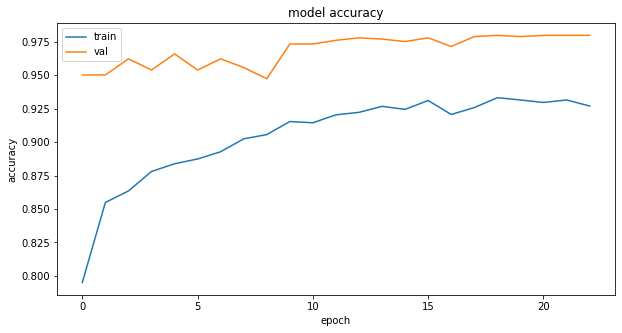

In [22]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

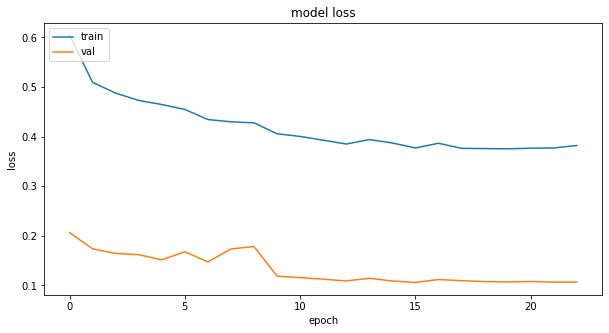

In [23]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
test_dataset = image_data_generator.flow_from_directory(test_root, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 2168 images belonging to 3 classes.


271/271 [==============================] - 38s 135ms/step
[0 0 0 ... 2 2 2]


<AxesSubplot:>

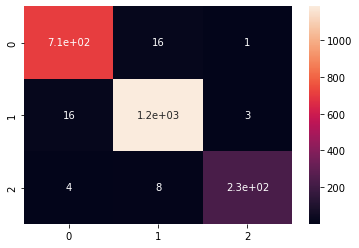

In [25]:
import seaborn as sns
predict_x = model.predict(test_dataset) 
pred = np.argmax(predict_x,axis=1)
print(pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, pred)
sns.heatmap(cm, annot=True)


In [26]:
print(cm)

[[ 707   16    1]
 [  16 1184    3]
 [   4    8  229]]


In [27]:
print((cm[0,0]+cm[1,1]+cm[2,2])/(sum(sum(cm))))

0.977859778597786


In [28]:
model.evaluate(test_dataset, batch_size=batch_size)

271/271 [==============================] - 13s 49ms/step - loss: 0.1014 - tp: 2115.0000 - fp: 42.0000 - tn: 4294.0000 - fn: 53.0000 - accuracy: 0.9779 - precision: 0.9805 - recall: 0.9756


[0.10142496228218079,
 2115.0,
 42.0,
 4294.0,
 53.0,
 0.9778597950935364,
 0.9805285334587097,
 0.9755535125732422]

In [29]:
test_root_2 = "G:/大学学习/NTU/dataset/Chest X-Ray (Pneumonia,Covid-19,Tuberculosis)/train"

In [30]:
test_dataset_2 = image_data_generator.flow_from_directory(test_root_2, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 2451 images belonging to 3 classes.


In [31]:
test_dataset_2.class_indices

{'COVID19': 0, 'NORMAL': 1, 'TURBERCULOSIS': 2}

307/307 [==============================] - 50s 163ms/step
[0 0 0 ... 1 0 0]


<AxesSubplot:>

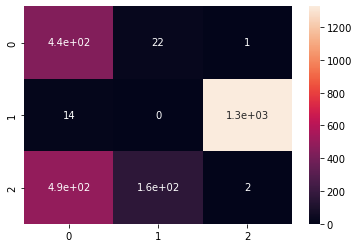

In [32]:
import seaborn as sns
predict_x = model.predict(test_dataset_2) 
pred = np.argmax(predict_x,axis=1)
print(pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset_2.classes, pred)
sns.heatmap(cm, annot=True)


In [33]:
print((cm[0,0]+cm[1,2]+cm[2,1])/(sum(sum(cm))))

0.7837617299061608


In [34]:
test_root_3 = "G:/大学学习/NTU/dataset/Covid-19 Image Dataset"

In [35]:
test_dataset_3 = image_data_generator.flow_from_directory(test_root_3, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 248 images belonging to 2 classes.


31/31 [==============================] - 9s 287ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 0 0 2 2
 0 0 2 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 2 0 2 0 2 0 0 2 2 2 0 0 2 2 2 2 2 2
 0 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2]


<AxesSubplot:>

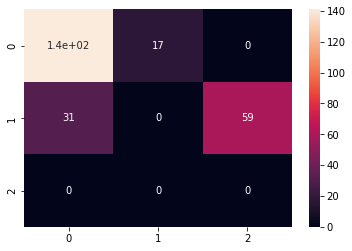

In [36]:
import seaborn as sns
predict_x = model.predict(test_dataset_3) 
pred = np.argmax(predict_x,axis=1)
print(pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset_3.classes, pred)
sns.heatmap(cm, annot=True)


In [37]:
print((cm[0,0]+cm[1,2])/(sum(sum(cm))))

0.8064516129032258


In [38]:
cm

array([[141,  17,   0],
       [ 31,   0,  59],
       [  0,   0,   0]], dtype=int64)

In [39]:
test_root_4 = "G:/大学学习/NTU/dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset"

In [40]:
test_dataset_4 = image_data_generator.flow_from_directory(test_root_4, target_size=(224,224), color_mode='rgb', batch_size=batch_size, shuffle=False)

Found 4589 images belonging to 2 classes.


574/574 [==============================] - 112s 195ms/step
[0 0 0 ... 2 2 2]


<AxesSubplot:>

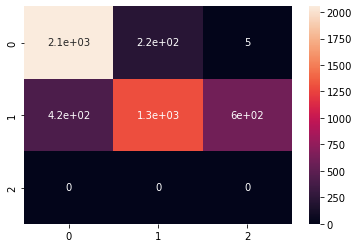

In [41]:
import seaborn as sns
predict_x = model.predict(test_dataset_4) 
pred = np.argmax(predict_x,axis=1)
print(pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset_4.classes, pred)
sns.heatmap(cm, annot=True)


In [42]:
print((cm[0,0]+cm[1,2]+cm[1,1])/(sum(sum(cm))))

0.8611898016997167


In [43]:
cm

array([[2054,  217,    5],
       [ 415, 1298,  600],
       [   0,    0,    0]], dtype=int64)